# 📊 Unemployment Analysis — India

**Dataset columns (expected):**  
`Region`, `Date`, `Frequency`, `Estimated Unemployment Rate (%)`, `Estimated Employed`, `Estimated Labour Participation Rate (%)`, `Area` (Rural/Urban)

**Notebook objective:**  
Load and clean the dataset, perform an exploratory data analysis (EDA), create polished static + interactive visualizations, and summarize key insights about unemployment trends across regions and time.


In [ ]:
%pip install plotly


# --- Imports & plotting settings ---
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Static plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive plotting
import plotly.express as px
import plotly.io as pio

# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)
sns.set(style="whitegrid")

# Optional: change plotly renderer if in notebook
# If running in VS Code interactive, 'notebook' or 'iframe' generally works
pio.renderers.default = "notebook"  # try 'notebook' or 'iframe' if necessary


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\gddas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
# Try a few common filenames to locate the dataset in the current folder
possible_filenames = [
    "Unemployment in India.csv",
    "Unemployment.csv",
    "unemployment.csv",
    "Unemployment_in_India.csv",
    "data/Unemployment in India.csv",
    "data/Unemployment.csv"
]

filename = None
for fn in possible_filenames:
    if os.path.exists(fn):
        filename = fn
        break

if filename is None:
    raise FileNotFoundError(
        "Dataset not found in working directory. Place the dataset in the same folder as the notebook "
        "or update the filename list in this cell."
    )

print("Loading dataset:", filename)
df = pd.read_csv(filename, encoding='utf-8', low_memory=False)
df.head()


Loading dataset: Unemployment in India.csv


,Region,Date,Frequency,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Area
0,Andhra Pradesh,31-05-2019,Monthly,3.65,11999139.0,43.24,Rural
1,Andhra Pradesh,30-06-2019,Monthly,3.05,11755881.0,42.05,Rural
2,Andhra Pradesh,31-07-2019,Monthly,3.75,12086707.0,43.50,Rural
3,Andhra Pradesh,31-08-2019,Monthly,3.32,12285693.0,43.97,Rural
4,Andhra Pradesh,30-09-2019,Monthly,5.17,12256762.0,44.68,Rural


In [11]:
# Standardize column names to safe snake_case keys and show mapping
def clean_colname(s):
    s = str(s).strip()
    s = s.replace("%", "pct")         # replace % with pct
    s = s.replace("(", "").replace(")", "")
    s = s.replace("/", "_")
    s = s.replace(".", "")
    s = s.replace("-", "_")
    s = "_".join(s.split())           # spaces -> underscore
    s = s.lower()
    return s

raw_cols = df.columns.tolist()
clean_cols = [clean_colname(c) for c in raw_cols]
col_map = dict(zip(raw_cols, clean_cols))
df.rename(columns=col_map, inplace=True)

print("Column mapping (original -> cleaned):")
for orig, clean in col_map.items():
    print(f"  {orig!r} -> {clean!r}")

print("\nCleaned column list:")
print(df.columns.tolist())


Column mapping (original -> cleaned):
  'region' -> 'region'
  'date' -> 'date'
  'frequency' -> 'frequency'
  'estimated_unemployment_rate_pct' -> 'estimated_unemployment_rate_pct'
  'estimated_employed' -> 'estimated_employed'
  'estimated_labour_participation_rate_pct' -> 'estimated_labour_participation_rate_pct'
  'area' -> 'area'

Cleaned column list:
['region', 'date', 'frequency', 'estimated_unemployment_rate_pct', 'estimated_employed', 'estimated_labour_participation_rate_pct', 'area']


In [12]:
# Helper to find the best matching column by substring
def find_col(df, candidates):
    cols = df.columns
    for c in candidates:
        for col in cols:
            if c in col:
                return col
    return None

# Candidate substrings for expected columns
date_col = find_col(df, ["date", "dt"])
region_col = find_col(df, ["region", "state"])
unemp_col = find_col(df, ["unemployment_rate", "unemploy", "unemp", "estimated_unemployment_rate", "estimated_unemployment_rate_pct"])
employed_col = find_col(df, ["employed", "estimated_employed"])
labour_part_col = find_col(df, ["labour_participation", "labour_participation_rate", "labour_participation_rate_pct", "labor_participation"])
area_col = find_col(df, ["area", "rural", "urban", "sector"])

print("Detected columns:")
print(" date_col:", date_col)
print(" region_col:", region_col)
print(" unemp_col:", unemp_col)
print(" employed_col:", employed_col)
print(" labour_part_col:", labour_part_col)
print(" area_col:", area_col)

# If any core column missing, show a helpful error
required = {"date":date_col, "region":region_col, "unemployment_rate":unemp_col}
missing = [k for k,v in required.items() if v is None]
if missing:
    raise ValueError(f"Required column(s) not detected: {missing}. Check column names in dataset or adjust find_col candidates.")


Detected columns:
 date_col: date
 region_col: region
 unemp_col: estimated_unemployment_rate_pct
 employed_col: estimated_employed
 labour_part_col: estimated_labour_participation_rate_pct
 area_col: area


In [13]:
# Convert date column
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# Convert numeric columns
num_cols = []
if unemp_col: num_cols.append(unemp_col)
if employed_col: num_cols.append(employed_col)
if labour_part_col: num_cols.append(labour_part_col)

for col in num_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors='coerce')

# Trim whitespace in region and area
if region_col:
    df[region_col] = df[region_col].astype(str).str.strip()

if area_col:
    df[area_col] = df[area_col].astype(str).str.strip()

# Show a quick sample after conversions
df_sample = df[[date_col, region_col, unemp_col, employed_col, labour_part_col, area_col]].head(8)
df_sample


,date,region,estimated_unemployment_rate_pct,estimated_employed,estimated_labour_participation_rate_pct,area
0,2019-05-31,Andhra Pradesh,3.65,11999139.0,43.24,Rural
1,2019-06-30,Andhra Pradesh,3.05,11755881.0,42.05,Rural
2,2019-07-31,Andhra Pradesh,3.75,12086707.0,43.50,Rural
3,2019-08-31,Andhra Pradesh,3.32,12285693.0,43.97,Rural
4,2019-09-30,Andhra Pradesh,5.17,12256762.0,44.68,Rural
5,2019-10-31,Andhra Pradesh,3.52,12017412.0,43.01,Rural
6,2019-11-30,Andhra Pradesh,4.12,11397681.0,41.00,Rural
7,2019-12-31,Andhra Pradesh,4.38,12528395.0,45.14,Rural


In [14]:
print("Dataset shape:", df.shape)
print("\nData types:")
display(df.dtypes)

print("\nMissing values per column:")
display(df.isnull().sum().sort_values(ascending=False))

print("\nSummary statistics (numeric columns):")
display(df.describe().T)


Dataset shape: (768, 7)

Data types:


region                                             object
date                                       datetime64[ns]
frequency                                          object
estimated_unemployment_rate_pct                   float64
estimated_employed                                float64
estimated_labour_participation_rate_pct           float64
area                                               object
dtype: object


Missing values per column:


date                                       28
frequency                                  28
estimated_unemployment_rate_pct            28
estimated_labour_participation_rate_pct    28
estimated_employed                         28
region                                      0
area                                        0
dtype: int64


Summary statistics (numeric columns):


,count,mean,min,25%,50%,75%,max,std
date,740,2019-12-12 18:36:58.378378496,2019-05-31 00:00:00,2019-08-31 00:00:00,2019-11-30 00:00:00,2020-03-31 00:00:00,2020-06-30 00:00:00,NaN
estimated_unemployment_rate_pct,740.0,11.787946,0.0,4.6575,8.35,15.8875,76.74,10.721298
estimated_employed,740.0,7204460.025676,49420.0,1190404.5,4744178.5,11275489.5,45777509.0,8087988.429458
estimated_labour_participation_rate_pct,740.0,42.630122,13.33,38.0625,41.16,45.505,72.57,8.111094


In [25]:
# Drop rows missing the key info (date or region or unemployment rate)
df = df.dropna(subset=[date_col, region_col, unemp_col]).copy()
print("After drop, shape:", df.shape)

# Sort values before interpolation
df = df.sort_values([region_col, date_col])

# Use transform instead of apply for aligned indices
df[unemp_col] = df.groupby(region_col)[unemp_col].transform(lambda s: s.interpolate(method='linear', limit_direction='both'))

if employed_col:
    df[employed_col] = df.groupby(region_col)[employed_col].transform(lambda s: s.interpolate(method='linear', limit_direction='both'))

if labour_part_col:
    df[labour_part_col] = df.groupby(region_col)[labour_part_col].transform(lambda s: s.interpolate(method='linear', limit_direction='both'))

print("After interpolation, missing values:")
display(df[[date_col, region_col, unemp_col, employed_col, labour_part_col]].isnull().sum())


After drop, shape: (740, 11)
After interpolation, missing values:


date                                       0
region                                     0
estimated_unemployment_rate_pct            0
estimated_employed                         0
estimated_labour_participation_rate_pct    0
dtype: int64

In [16]:
df['year'] = df[date_col].dt.year
df['month'] = df[date_col].dt.month
df['month_name'] = df[date_col].dt.strftime("%b")
df['period'] = df[date_col].dt.to_period('M')  # monthly period

# Quick counts
print("Unique regions:", df[region_col].nunique())
print("Years covered:", df['year'].min(), "-", df['year'].max())

df.head()


Unique regions: 28
Years covered: 2019 - 2020


,region,date,frequency,estimated_unemployment_rate_pct,estimated_employed,estimated_labour_participation_rate_pct,area,year,month,month_name,period
0,Andhra Pradesh,2019-05-31,Monthly,3.65,11999139.0,43.24,Rural,2019,5,May,2019-05
373,Andhra Pradesh,2019-05-31,Monthly,6.09,4788661.0,37.45,Urban,2019,5,May,2019-05
1,Andhra Pradesh,2019-06-30,Monthly,3.05,11755881.0,42.05,Rural,2019,6,Jun,2019-06
374,Andhra Pradesh,2019-06-30,Monthly,3.80,4824630.0,36.76,Urban,2019,6,Jun,2019-06
2,Andhra Pradesh,2019-07-31,Monthly,3.75,12086707.0,43.50,Rural,2019,7,Jul,2019-07


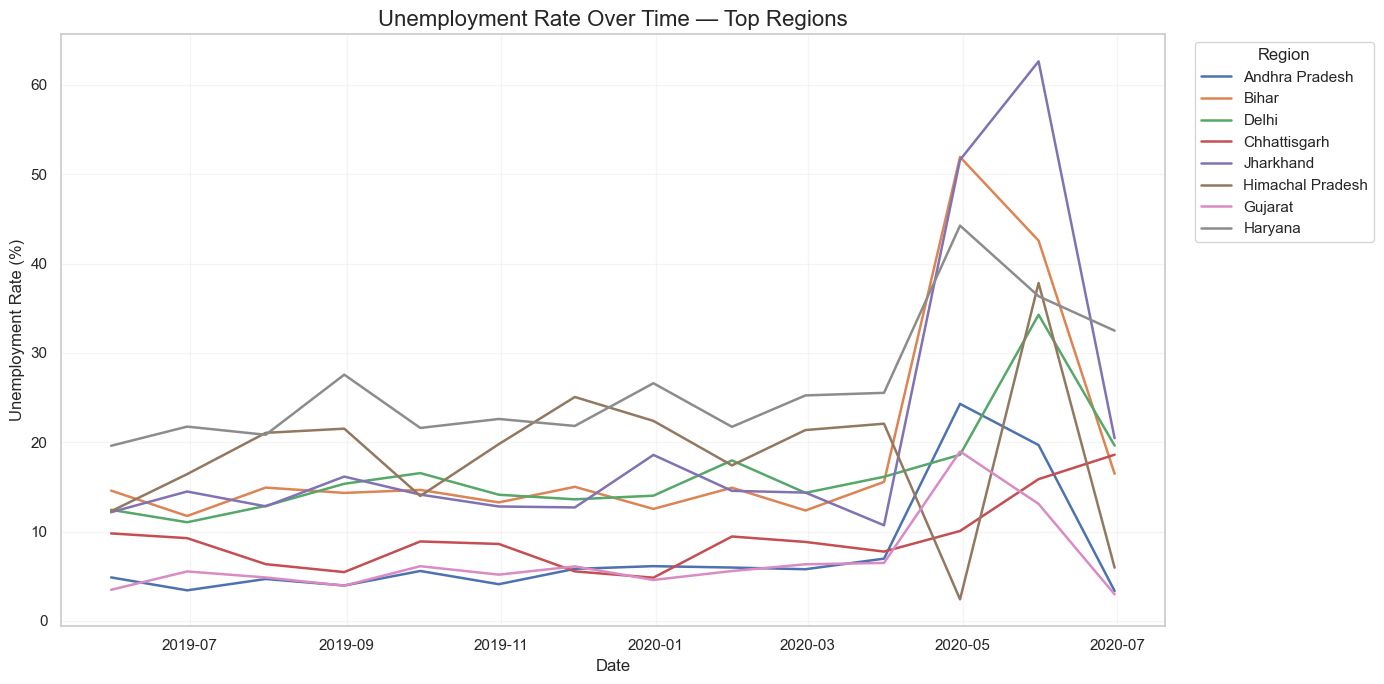

In [17]:
# Plot: Unemployment trends over time for top N regions by data points
top_regions = df[region_col].value_counts().nlargest(8).index.tolist()

plt.figure(figsize=(14,7))
for r in top_regions:
    subset = df[df[region_col] == r]
    # resample monthly average (in case there are multiple entries per month)
    ts = subset.set_index(date_col).resample('M')[unemp_col].mean()
    plt.plot(ts.index, ts.values, label=r, linewidth=1.8)

plt.title("Unemployment Rate Over Time — Top Regions", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.legend(title="Region", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()


**Explanation:** The line chart above shows monthly unemployment rate trends for the top regions (by data availability). Look for spikes/dips that correspond to major events (for example: economic shocks, lockdowns, seasonal effects).  


**Explanation:** Use this interactive chart to zoom into specific time ranges or to click a region in the legend to isolate its trend.


In [ ]:
# Compute region averages and plot (sorted)
region_avg = df.groupby(region_col)[unemp_col].mean().sort_values()

plt.figure(figsize=(10,12))
sns.barplot(x=region_avg.values, y=region_avg.index, palette="viridis")
plt.title("Average Unemployment Rate by Region", fontsize=16)
plt.xlabel("Average Unemployment Rate (%)")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


**Explanation:** This bar chart ranks regions by their average unemployment rate across the dataset period. Regions at the top show higher average unemployment and may require targeted policy attention.


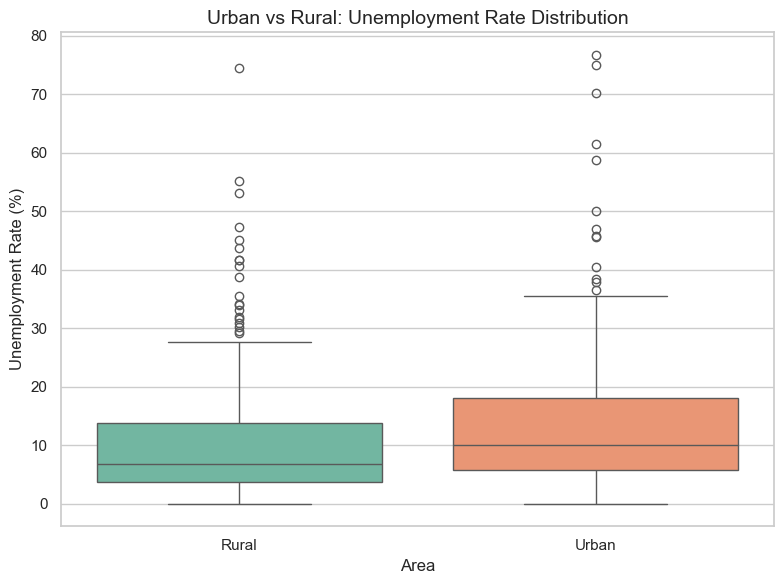

In [19]:
if area_col:
    plt.figure(figsize=(8,6))
    sns.boxplot(x=area_col, y=unemp_col, data=df, palette="Set2")
    plt.title("Urban vs Rural: Unemployment Rate Distribution", fontsize=14)
    plt.xlabel("Area")
    plt.ylabel("Unemployment Rate (%)")
    plt.tight_layout()
    plt.show()
else:
    print("No 'area' column detected — skipping urban/rural boxplot.")


**Explanation:** The boxplot shows distribution (median, IQR, outliers) of unemployment in Urban vs Rural areas. This highlights differences in spread and central tendency between the two sectors.


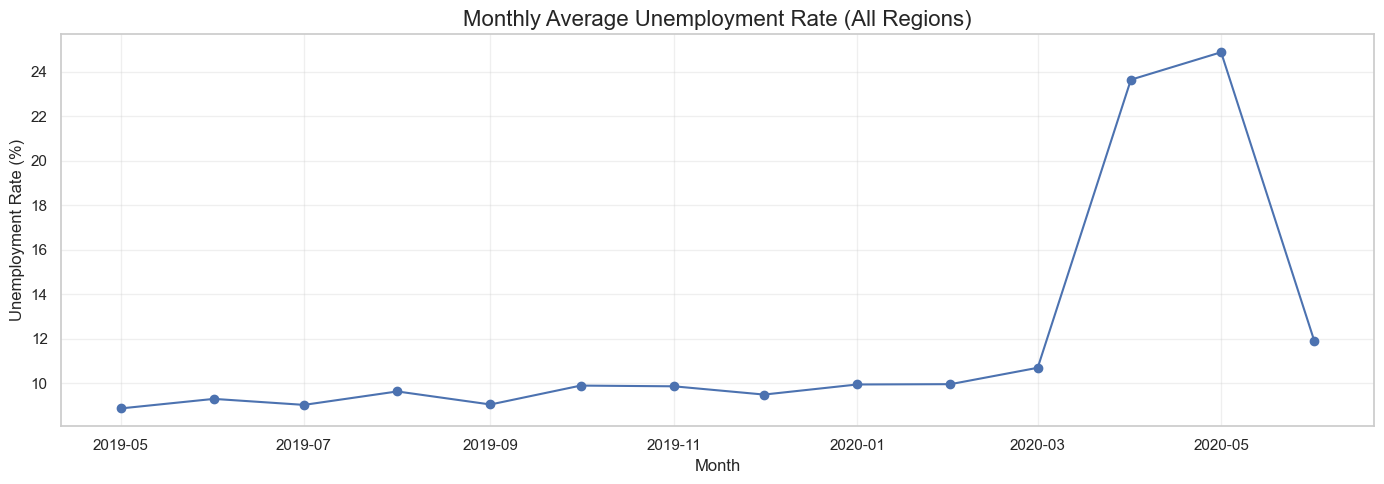

In [20]:
# Monthly average across all regions (ordered)
monthly_mean = df.groupby('period')[unemp_col].mean()
monthly_mean.index = monthly_mean.index.to_timestamp()

plt.figure(figsize=(14,5))
plt.plot(monthly_mean.index, monthly_mean.values, marker='o')
plt.title("Monthly Average Unemployment Rate (All Regions)", fontsize=16)
plt.ylabel("Unemployment Rate (%)")
plt.xlabel("Month")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Explanation:** This shows how unemployment behaves seasonally or during extraordinary events across the entire country (aggregated).


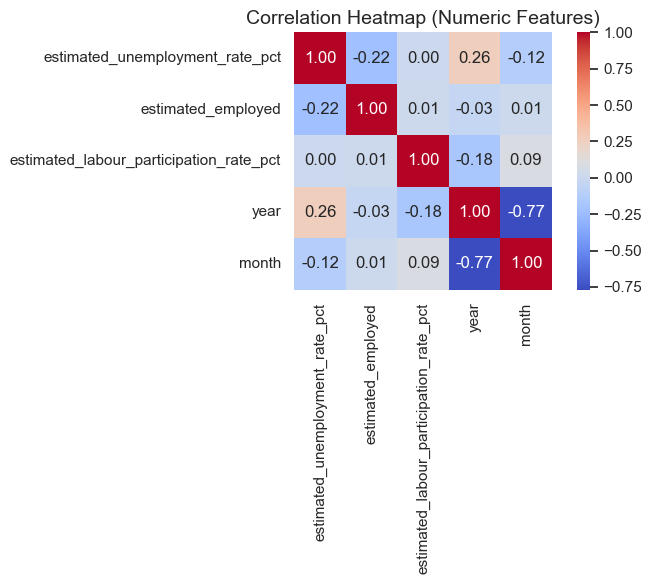

In [21]:
# Compute correlation of numeric columns
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 2:
    plt.figure(figsize=(8,6))
    sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap (Numeric Features)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns found for correlation heatmap.")


**Explanation:** Correlations indicate linear relationships between numeric columns like unemployment, employed, and labour participation rates. Use this as an initial check for associations.


## ✅ Conclusion and Recommendations

- **Trends:** The monthly and regional trend plots show how unemployment changes over time and identify regions with persistently high unemployment.
- **Regional difference:** Some regions show consistently higher average unemployment — these may be prioritized for intervention.
- **Urban vs Rural:** The boxplot highlights distributional differences between Urban and Rural areas (if available).
- **Policy implications:** Tailored employment programs and close monitoring around identified spike months (e.g., during economic shocks) can be beneficial.

